In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Currently data is in directories like

#########################################################
# With this the whole file structure had to be changed.
# TODO Use code for test train split, currently the last 10 or so files are used as test, not randomly
#   For test/train split
#       get list of positives and negatives, test/train split the list.
#       move all filenames in that list to either test, or train directory
#########################################################

In [3]:
# Try a new CNN with the input data augmented so it will classify obscured spheres
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# CNN has been trained previously, just loading in weights so commented out
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Made this into a function so that I can rerun and load weights
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(51, 51, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

########################################################## New Cell? #########################################

batch_size = 16 # TODO find out what batch_size is

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.0,
        height_shift_range=0.0, # From 0.2 to 0 ONLY MIDDLE
        #zoom_range=[1,2],       # Changed to zoom out 5 -> 4 was too good
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'TrainingImages/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'TrainingImages/train',  # this is the target directory
        target_size=(51, 51),  # all images will be resized to 51x51
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'TrainingImages/test',
        target_size=(51, 51),
        batch_size=batch_size,
        class_mode='binary')

# TODO search more about these hyperparameters
# steps_per_epoch???? 

model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=5,       # Can Increase later but I dont think more epochs really help it
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

model.save('CNN_Model.h5')


Using TensorFlow backend.
Found 2830 images belonging to 2 classes.
Found 95 images belonging to 2 classes.
Epoch 1/5
125/125 [==============================] - 14s 115ms/step - loss: 0.0512 - accuracy: 0.9850 - val_loss: 7.5681e-05 - val_accuracy: 1.0000
Epoch 2/5
125/125 [==============================] - 11s 90ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 1.4395e-07 - val_accuracy: 1.0000
Epoch 3/5
125/125 [==============================] - 9s 73ms/step - loss: 0.0222 - accuracy: 0.9990 - val_loss: 7.7540e-08 - val_accuracy: 1.0000
Epoch 4/5
125/125 [==============================] - 9s 70ms/step - loss: 9.5798e-06 - accuracy: 1.0000 - val_loss: 1.0098e-07 - val_accuracy: 1.0000
Epoch 5/5
125/125 [==============================] - 8s 61ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 5.9104e-10 - val_accuracy: 1.0000


In [4]:
# Load model
from tensorflow import keras

model = keras.models.load_model('CNN_Model.h5')

# Classifier is trained
Now the classifier has been sufficiently trained we can use it on the pacman data

1 - First I will define the functions I created for the task

2 - Then I will use the PacMan code to play the game 

In [5]:
############### OLD BUT KEPT FOR REFERENCE #####################
# Define function sliding window
# returns array of windows that I can classify at once
def sliding_window( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []

    for y in range(0, image_hight-window_size, step_size):   # Verticle
        for x in range (0, image_width-window_size, step_size):   #horizontal
            windows.append(image[y:y+window_size, x:x+window_size, :])
    print('Number of windows: {}'.format(len(windows)))

    return np.array(windows) # Return windows as np array

# This function goes through windows in an image, 
# The function takes in step_size
# Returns the x,y coordinates of the start of window containing spheres, and distance to sphere as a np array
def sliding_window_classifier( step_size, image, mapx, mapy, mapz, depth ):    # REMOVE MAPX,Y,Z
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    result = []

    for y in range(0, image_hight-window_size, step_size): 
        for x in range (0, image_width-window_size, step_size):

            window = image[y:y+window_size, x:x+window_size, :]

            #Normaly you predict on an array of value, but here since we want the (x,y) coordinates this is easier
            window = np.expand_dims(window, axis=0) # Adds first dimension to data (1,51,51,3) -> (1,51,51,3)
            prediction = model.predict( np.array( window ) )
            prediction = prediction[0][0] #  Unpack prediction [[1.]] -> 1

            # Only want patches we are 100% sure contain spheres
            if (prediction == 1):                
                print(f'Middle pixel Depth: {depth[y+25, x+25]}')   # TODO call depth as a parameter or ensure it is correct
                print(f'Coordinates of sphere: {[mapx[y+25, x+25], mapy[y+26, x+26], mapz[y+26, x+26]]}')

                plt.figure(figsize=(2,1))
                plt.title('Image')
                plt.imshow( window[0,:,:,:] )   
        
                # Add 'crosshair' to show middle pixel
                ax=plt.gca() 
                ax.spines['left'].set_position('center')
                ax.spines['bottom'].set_position('center')
                ax.xaxis.set_ticks_position('bottom')
                ax.yaxis.set_ticks_position('left')
                plt.show()

                # Spheres are always in the centre of the window.
                # Middle depth is the depth of the pixel in the centre of the sphere and window.
                middle_depth = depth[y+25, x+25]

                # Need these to be returned so we can move to the closest sphere.
                result.append( (x, y, middle_depth) )

    # Results are np array with columns: x, y, depth
    # If length is 0 then no spheres were found
    return np.asarray(result)   

# Not for task but function to nicely visualise allmaps
def visualise_maps(image, mapx, mapy, mapz, depth):
    # Inputs can be full 160x240 or 51x51 in size
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

    ax[0].set_title('image')
    im0 = ax[0].imshow(image)
    #fig.colorbar(im, ax=ax[0])

    ax[1].set_title('mapx')
    im1 = ax[1].imshow(mapx, cmap='bwr')
    fig.colorbar(im1, ax=ax[1])

    ax[2].set_title('mapy')
    im2 = ax[2].imshow(mapy, cmap='bwr')
    fig.colorbar(im2, ax=ax[2])

    ax[3].set_title('mapz')
    im3 = ax[3].imshow(mapz, cmap='bwr')
    fig.colorbar(im3, ax=ax[3])

    ax[4].set_title('depth')
    im4 = ax[4].imshow(depth, cmap='bwr')
    fig.colorbar(im4, ax=ax[4])
    plt.show()
    print()


# This will change a lot
# First draft here to make code less messy
def sphere_position(x, y, position, spheres_collected):
    # x,y
    # Given coordinates of sphere, 
    #   find x, y, z of sphere
    #   set that as position

    # For now going with move to middle pixel

    newx = mapx[y+25, x+25] #-0.2603576553033593    # I want Y, X not X, Y 
    newy = mapy[y+25, x+25] #0.04575819465891324
    newz = mapz[y+25, x+25] #2.330109222847228

    # Spheres location specified with 2dp so no point in using more than that.
    newx = np.round(newx, decimals=2) #-0.26
    newy = np.round(newy, decimals=2) #0.04
    newz = np.round(newz, decimals=2) #2.33

    print(f'I am at position {position}')
    print(f'I have found {np.sum(spheres_collected)} out of {len(spheres_collected)} spheres!\n')

    # Move position and update scene
    position = np.asarray([newx, newy, newz])
    print(f'I am now at position {position}')

    #IndexError: index 0 is out of bounds for axis 0 with size 0 -> error with spheres_collected normally
    global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
    print(f'I have found {np.sum(spheres_collected)} out of {len(spheres_collected)} spheres!\n')

    #print([newx, newy, newz])
    print('####################################################################################################################')

    # Fixed error where spheres_collected wouldnt update as it wasnt returned
    return global_cloud, spheres_collected, position

Start time:
13:31:52
Getting maps.... may take a while


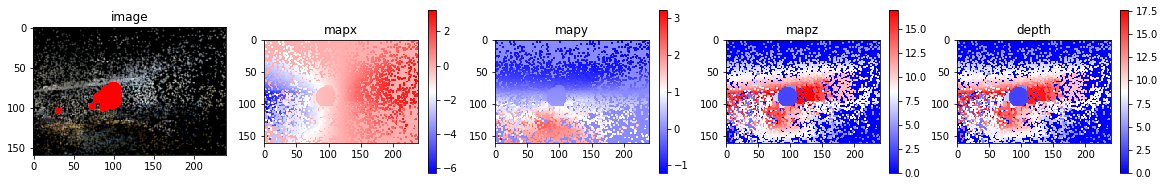


I have rotation  [0, 0, 0]
Middle pixel Depth: 2.362394660377316
Coordinates of sphere: [-0.18864053057926217, -0.019816509555381334, 2.3452208318322474]


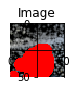

Middle pixel Depth: 2.3450562704232105
Coordinates of sphere: [-0.2603576553033593, 0.05510028477643353, 2.3234853872846455]


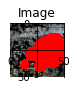

Middle pixel Depth: 2.3181017490588016
Coordinates of sphere: [-0.1871206860642045, 0.057547847669428775, 2.309382003932991]


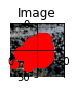

Middle pixel Depth: 2.33835638996628
Coordinates of sphere: [-0.1279808048824868, 0.049903917105603365, 2.3402081891374236]


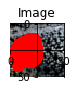

Middle pixel Depth: 2.358445152176713
Coordinates of sphere: [-0.26208158696191186, 0.11313504329078472, 2.3402081891374236]


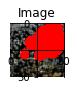

Middle pixel Depth: 2.3277173228264916
Coordinates of sphere: [-0.1930984786272424, 0.11221951931464859, 2.3209992750901813]


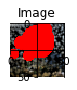

Middle pixel Depth: 2.351087945921528
Coordinates of sphere: [-0.12771209021554739, 0.11419926943461708, 2.3589974646668743]


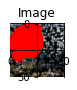

I am at position [0 0 0]
I have found 0 out of 11 spheres!

I am now at position [-0.19  0.05  2.31]
I have found 1 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


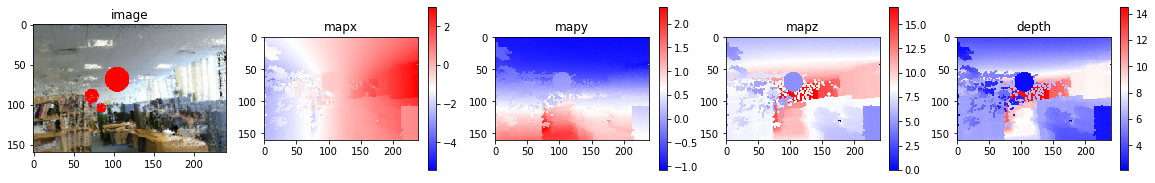


I have rotation  [0, 0, 0]
Middle pixel Depth: 2.390371509554125
Coordinates of sphere: [-0.3768165696540129, -0.04906330628107482, 4.68461915824882]


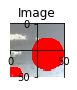

Middle pixel Depth: 2.370635636619662
Coordinates of sphere: [-0.3148967762428964, -0.04855155502685089, 4.67416503318728]


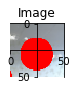

Middle pixel Depth: 2.3944542815445167
Coordinates of sphere: [-0.3771248353235815, 0.0072684363986539186, 4.69554614905699]


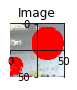

Middle pixel Depth: 2.37370019660035
Coordinates of sphere: [-0.3149121905175097, 0.00651392310551023, 4.683132969262728]


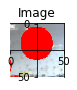

I am at position [-0.19  0.05  2.31]
I have found 1 out of 11 spheres!

I am now at position [-0.31 -0.06  4.67]
I have found 2 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


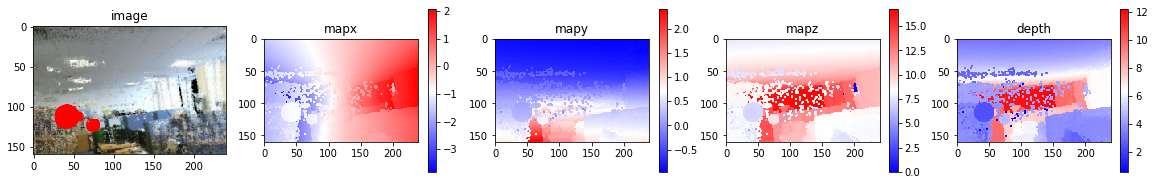


I have rotation  [0, 0, 0]
Middle pixel Depth: 2.457483262648013
Coordinates of sphere: [-0.9666207619611805, 0.15492680554916877, 7.022485387284645]


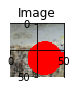

Middle pixel Depth: 2.4478208621168256
Coordinates of sphere: [-0.912347198869453, 0.15577136148278084, 7.032285510295741]


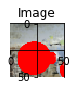

Middle pixel Depth: 2.44192294721639
Coordinates of sphere: [-0.9610005444780028, 0.20897135127630662, 7.008012236115336]


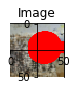

Middle pixel Depth: 2.4349519067116865
Coordinates of sphere: [-0.908000852380727, 0.2108354248081529, 7.01921915824882]


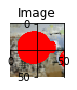

Middle pixel Depth: 2.484390349136627
Coordinates of sphere: [-0.8438576923384195, 0.21957126626226195, 7.098179853934919]


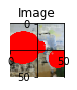

Middle pixel Depth: 2.483292216321957
Coordinates of sphere: [-0.9699726089809048, 0.2933961483218085, 7.048175112250146]


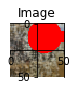

Middle pixel Depth: 2.474960839876852
Coordinates of sphere: [-0.9129131377975138, 0.295398428802626, 7.059463689446778]


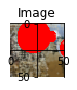

I am at position [-0.31 -0.06  4.67]
I have found 2 out of 11 spheres!

I am now at position [-0.91  0.2   7.02]
I have found 3 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


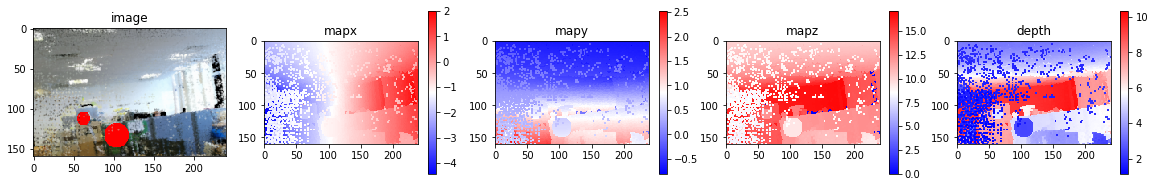


I have rotation  [0, 0, 0]
Middle pixel Depth: 2.414704068577953
Coordinates of sphere: [-1.031278396772084, 0.4513351023197174, 8.625673294067383]


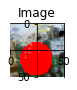

I am at position [-0.91  0.2   7.02]
I have found 3 out of 11 spheres!

I am now at position [-1.03  0.57  9.4 ]
I have found 4 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


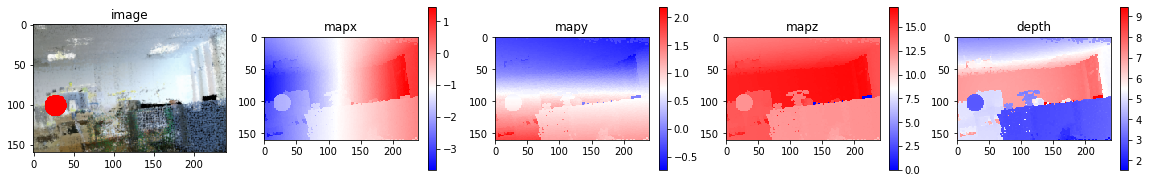


I have rotation  [0, 0, 0]
Middle pixel Depth: 2.9272463658828665
Coordinates of sphere: [-1.901103060836221, 0.732226040670788, 12.187832591106236]


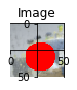

Middle pixel Depth: 2.916744386205904
Coordinates of sphere: [-1.8969125076961122, 0.7975992573346649, 12.179527053744982]


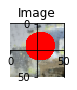

Middle pixel Depth: 2.930285206062414
Coordinates of sphere: [-1.8384905587360607, 0.8001337289856061, 12.21709921626078]


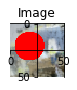

I am at position [-1.03  0.57  9.4 ]
I have found 4 out of 11 spheres!

I am now at position [-1.9   0.79 12.18]
I have found 5 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


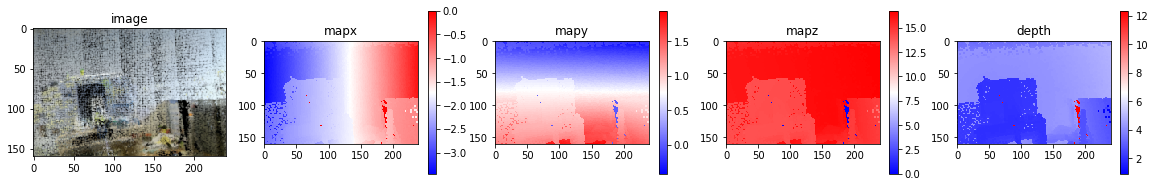


I have rotation  [0, 0, 0]
### No spheres found, rotating
Getting maps.... may take a while


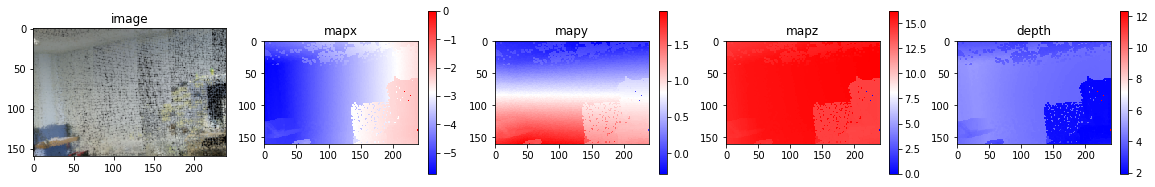


I have rotation  [0.0, -0.5235987755982988, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


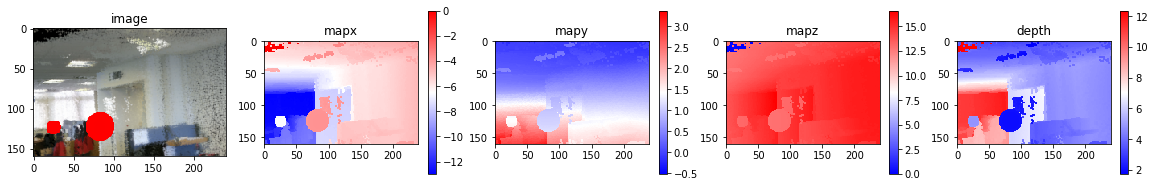


I have rotation  [0.0, -1.0471975511965976, 0.0]
Middle pixel Depth: 2.028298011654881
Coordinates of sphere: [-3.770943618128653, 1.036730501791769, 12.929428593740479]


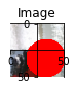

Middle pixel Depth: 2.017023351448333
Coordinates of sphere: [-3.7424773805068154, 1.0383046829832734, 12.97636807829372]


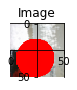

Middle pixel Depth: 2.0174744888784053
Coordinates of sphere: [-3.7549860759630995, 1.085118625096548, 12.924120831832248]


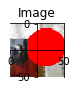

Middle pixel Depth: 2.008260889557772
Coordinates of sphere: [-3.728223055876755, 1.0843642017648456, 12.966228852751968]


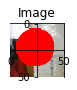

Middle pixel Depth: 2.034307155554521
Coordinates of sphere: [-3.7252112482837236, 1.09096477856483, 13.03817498264214]


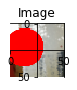

I am at position [-1.9   0.79 12.18]
I have found 5 out of 11 spheres!

I am now at position [-3.73  1.08 12.96]
I have found 6 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


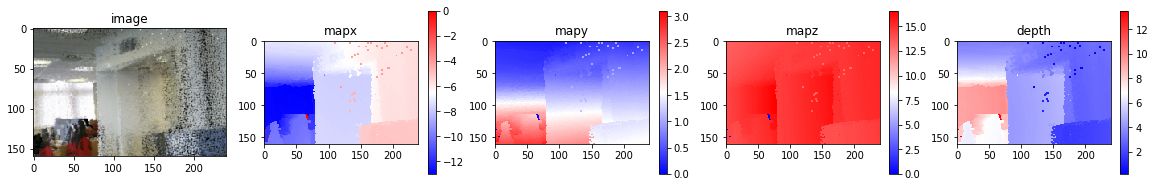


I have rotation  [0.0, -1.0471975511965976, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


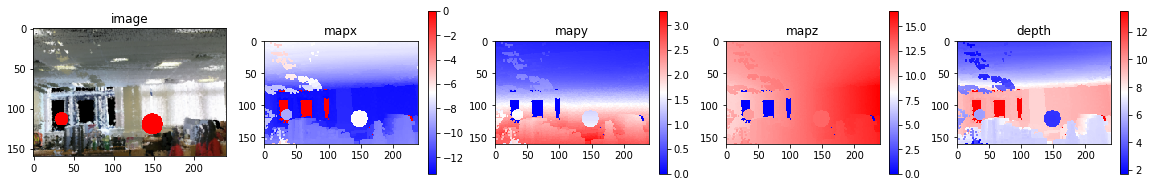


I have rotation  [0.0, -1.5707963267948966, 0.0]
Middle pixel Depth: 2.8699422311060276
Coordinates of sphere: [-6.568284901426976, 1.4322379383546064, 13.21924430756249]


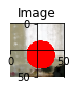

Middle pixel Depth: 2.871749799909968
Coordinates of sphere: [-6.560960877319874, 1.5001897550301495, 13.21924430756249]


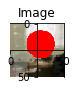

Middle pixel Depth: 2.883496059912337
Coordinates of sphere: [-6.566218942023345, 1.502482033588346, 13.288428186011302]


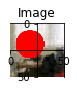

I am at position [-3.73  1.08 12.96]
I have found 6 out of 11 spheres!

I am now at position [-6.57  1.42 13.21]
I have found 7 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


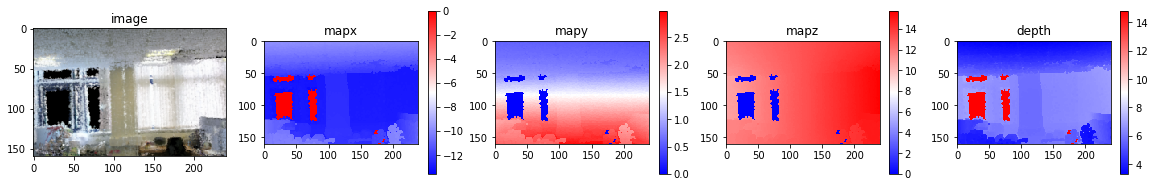


I have rotation  [0.0, -1.5707963267948966, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


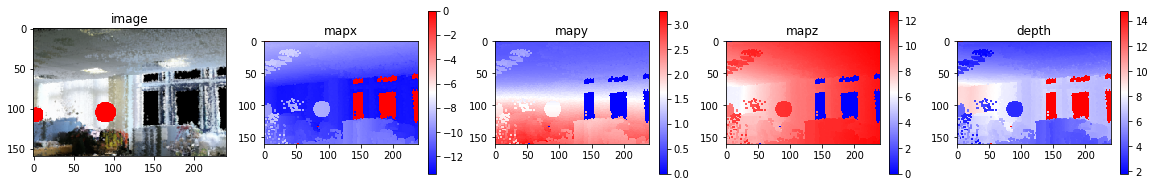


I have rotation  [0.0, -2.0943951023931953, 0.0]
Middle pixel Depth: 2.8844353976387955
Coordinates of sphere: [-8.884421654800297, 1.6587699305425412, 11.513223817622789]


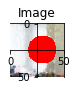

Middle pixel Depth: 2.8865192910342943
Coordinates of sphere: [-8.924894071290968, 1.663119246710532, 11.564014612715354]


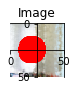

I am at position [-6.57  1.42 13.21]
I have found 7 out of 11 spheres!

I am now at position [-8.88  1.66 11.51]
I have found 8 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


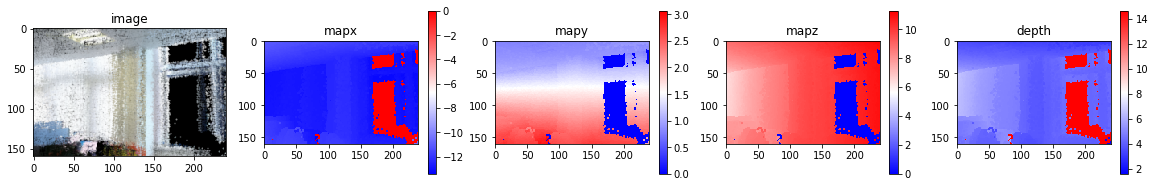


I have rotation  [0.0, -2.0943951023931953, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


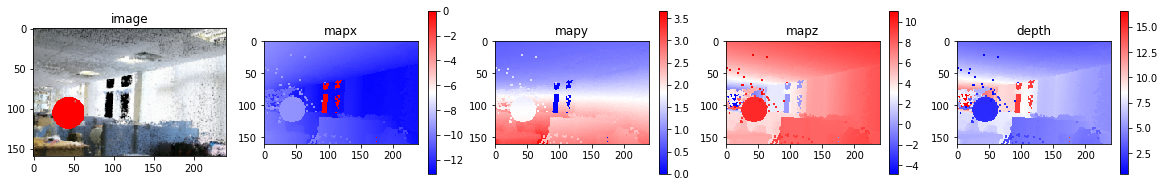


I have rotation  [0.0, -2.617993877991494, 0.0]
Middle pixel Depth: 1.8380691958615654
Coordinates of sphere: [-9.337737621909147, 1.7621459597954883, 9.740579096147073]


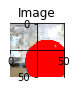

Middle pixel Depth: 1.8256155087678756
Coordinates of sphere: [-9.376741174792121, 1.7624812770676923, 9.759967484596475]


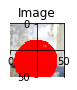

Middle pixel Depth: 1.8443487637114566
Coordinates of sphere: [-9.434768105210539, 1.7628751646764185, 9.754895001375075]


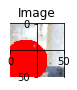

Middle pixel Depth: 1.819747254672273
Coordinates of sphere: [-9.332376396528938, 1.8069622251923705, 9.756990777152772]


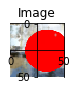

Middle pixel Depth: 1.8107076517808791
Coordinates of sphere: [-9.371531844723389, 1.8092684657606608, 9.77427304649531]


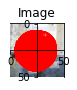

Middle pixel Depth: 1.8257007519070065
Coordinates of sphere: [-9.427298614696312, 1.8151052194711483, 9.77329922386648]


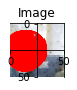

Middle pixel Depth: 1.8310769224844377
Coordinates of sphere: [-9.333540774179795, 1.861952505511033, 9.748096514157934]


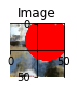

Middle pixel Depth: 1.8210523735967945
Coordinates of sphere: [-9.374424214322815, 1.8627542967319595, 9.76688084175118]


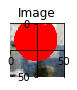

Middle pixel Depth: 1.8397647337669143
Coordinates of sphere: [-9.430949880047534, 1.8674014590610943, 9.759967484596475]


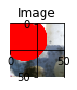

Middle pixel Depth: 1.8979726697044579
Coordinates of sphere: [-9.391355297264543, 2.7747929096221924, 4.425738334655762]


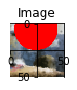

I am at position [-8.88  1.66 11.51]
I have found 8 out of 11 spheres!

I am now at position [-9.37  1.81  9.77]
I have found 9 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


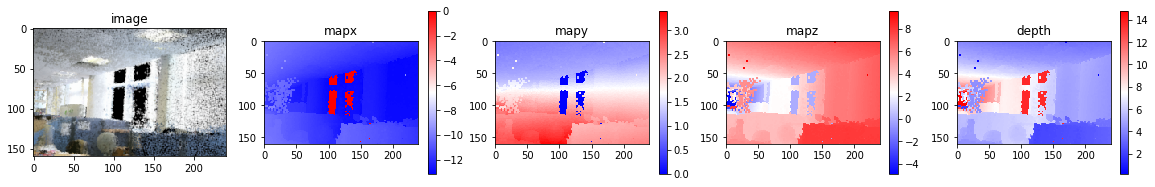


I have rotation  [0.0, -2.617993877991494, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


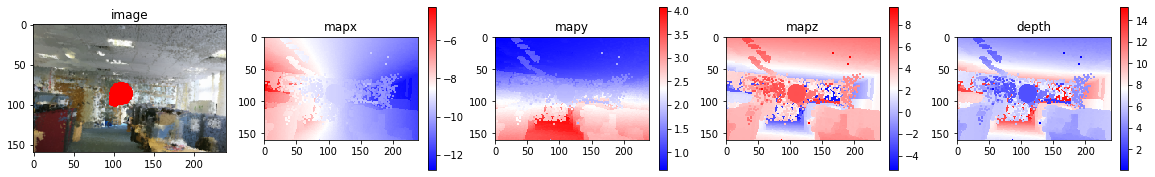


I have rotation  [0.0, -3.1415926535897927, 0.0]
Middle pixel Depth: 2.508747841590387
Coordinates of sphere: [-9.256992214641356, 1.8701715540492336, 7.265817996067009]


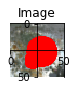

Middle pixel Depth: 2.5125821437852887
Coordinates of sphere: [-9.31571769365871, 1.8613404022238496, 7.25498084175118]


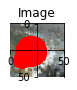

Middle pixel Depth: 2.525245334948346
Coordinates of sphere: [-9.256434435872997, 1.9332578142426833, 7.246105524158335]


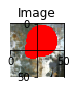

Middle pixel Depth: 2.529129987914794
Coordinates of sphere: [-9.31531312818052, 1.933547899299598, 7.232523644065813]


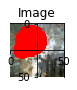

I am at position [-9.37  1.81  9.77]
I have found 9 out of 11 spheres!

I am now at position [-9.26  1.86  7.26]
I have found 10 out of 11 spheres!

####################################################################################################################
Getting maps.... may take a while


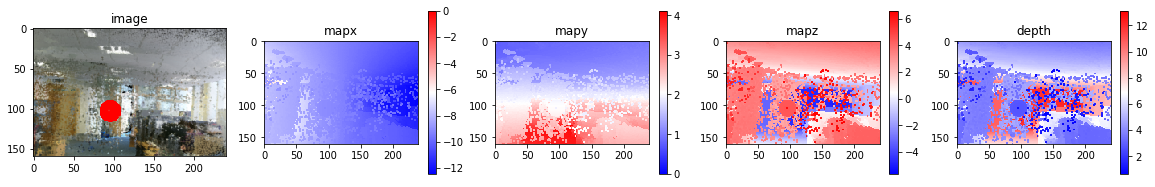


I have rotation  [0.0, -3.1415926535897927, 0.0]
Middle pixel Depth: 2.7208465699815387
Coordinates of sphere: [-9.039621541722369, 2.080866470166812, 4.556868592637015]


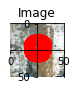

Middle pixel Depth: 2.7484869535025993
Coordinates of sphere: [-9.109567420131839, 2.0852577076364565, 4.51420078373922]


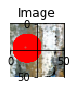

Middle pixel Depth: 2.7674303092991908
Coordinates of sphere: [-9.041589348721137, 2.177050852639651, 4.50415539607955]


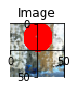

I am at position [-9.26  1.86  7.26]
I have found 10 out of 11 spheres!

I am now at position [-9.04  2.07  4.56]
I have found 11 out of 11 spheres!

####################################################################################################################


In [18]:
################ TEST ##################
# Took 24 minutes on PC
#   18 minutes on laptop
#   12 minutes on google

# Initilise game
from datetime import datetime
print('Start time:')
print(datetime.now().strftime('%H:%M:%S') )

import PacMan_functionality as PacMan
global_cloud, spheres_collected = PacMan.startup_scene()    # Have to use subsample, it effects acuracy but its way too slow otherwise
position = np.asarray([0, 0, 0])
angle = np.asarray([0, 0, 0])

while not np.all(spheres_collected): # While there are spheres to find
    # Get current image from viewpoint
    print('Getting maps.... may take a while')
    image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)
    visualise_maps(image, mapx, mapy, mapz, depth)

    print('I have rotation  [{0}, {1}, {2}]'.format(*angle))

    # Extract patches from the scene    
    # Extract features from the patches

    #res = sliding_window_classifier(20, image)  # Return list of x,y,predict,depth # 20 leads to some individual picking up pixels error
    res = sliding_window_classifier(10, image, mapx, mapy, mapz, depth)

    # Predict the probability of a pixel being a sphere, based on the patch    
    # Use probabilities to find sphere coordinates in 3D

    if (len(res) > 0 ): # If spheres were found
        min_index = np.argmin(res[:,2])
        x = int(res[min_index, 0])    # From float to int
        y = int(res[min_index, 1])    

        # Get spacial coordinates of new sphere
        # and move there apparantly
        global_cloud, spheres_collected, position = sphere_position(x, y, position, spheres_collected)  

    else:   # No spheres found
        print('### No spheres found, rotating')
        #add pi/3 to roatation
        # Maybe reshow views?
        angle = angle - np.asarray([0, np.pi*1/6, 0])   # numpy + is an elementwise operation 
        #image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, new_angle, position)
        #visualise_maps(image, mapx, mapy, mapz, depth) # Visualise after rotation

        continue


    # Update camera appropriately
    
    # Update scene if needed

In [0]:
from datetime import datetime
print('End time:')
print(datetime.now().strftime('%H:%M:%S') )

In [0]:
#

In [0]:
#[-11.947921752929688, 2.3431053161621094, 15.81285285949707]

In [0]:
#